In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
from scipy.stats import norm
from keras import layers
from keras import models
from keras import losses
import keras.backend as K
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = layers.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(input_img)
x = layers.Conv2D(64, 3, padding="same", activation="relu", strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, x)
z_decoded = decoder(z)

class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = losses.binary_crossentropy(x, z_decoded)
        # the original version, seems wrong
        # kl_loss = -5e-4 * K.mean(
        #     1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        xent_loss *= img_shape[0] * img_shape[1]
        kl_loss = -0.5 * K.sum(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x  # not used
y = CustomVariationalLayer()([input_img, z_decoded])

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
vae = models.Model(input_img, y)
vae.compile(optimizer="rmsprop", loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [5]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.astype('float32') / 255.
X_test = X_test.reshape(X_test.shape + (1,))
vae.fit(X_train, None, epochs=10,
        batch_size=batch_size, validation_data=(X_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 465us/step - loss: 169.3632 - val_loss: 159.0572
Epoch 2/10
60000/60000 [==============================] - 25s 421us/step - loss: 156.9159 - val_loss: 154.6006
Epoch 3/10
60000/60000 [==============================] - 25s 424us/step - loss: 153.6451 - val_loss: 155.6313
Epoch 4/10
60000/60000 [==============================] - 25s 423us/step - loss: 151.9557 - val_loss: 151.2423
Epoch 5/10
60000/60000 [==============================] - 25s 423us/step - loss: 150.8909 - val_loss: 150.9156
Epoch 6/10
60000/60000 [==============================] - 25s 424us/step - loss: 150.0655 - val_loss: 150.8712
Epoch 7/10
60000/60000 [==============================] - 25s 424us/step - loss: 149.4319 - val_loss: 149.1888
Epoch 8/10
60000/60000 [==============================] - 25s 424us/step - loss: 148.9031 - val_loss: 150.7696
Epoch 9/10
600

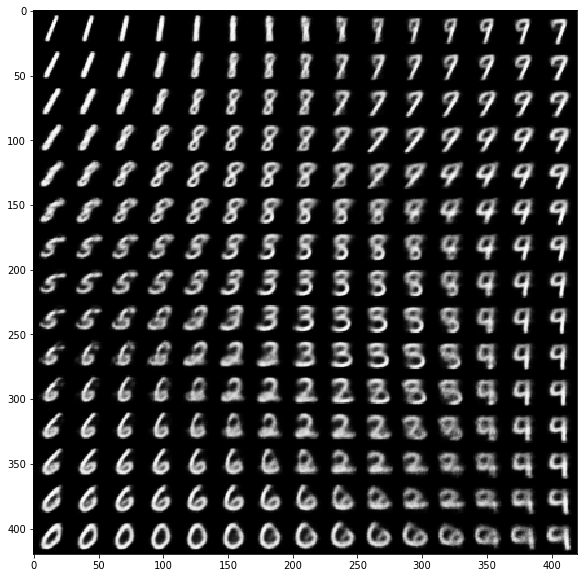

In [6]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()